# Python Tutorial 2
## MBP1201H Introduction to Biostatistics

In [1]:
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import norm, kstest, pearsonr, ttest_ind, zscore
from statsmodels.api import qqplot
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt

## Problem 1 - Normality Tests
Many statistical tests require the input distributions to be normal, or follow a Gaussian probability density function. We're going to investigate a couple of tests to determine if an arbitrary distribution can be considered normal. For this problem, we'll use the `np.random.normal()` function to generate a synthetic dataset `X` with mean 5 and standard deviation 1 from a normal distribution. 

### Part 1A - QQ Plots
Plot a histogram of X. Does it look visually normal? Use the `qqplot()` function to generate a Quantile-Quantile plot of X. Do the points align well with the identity line $y=x$?

### Part 1B - Kolmogorov-Smirnov Test

The Kolmogorov-Smirnov test compares two distributions $A$ and $B$ to determine if they are statistically the same distribution. In this case, we will use it to determine if a random distribution is normally distributed. What is the KS statistic of X with respect to the normal CDF `norm.cdf`? Is this statistically significant at the level $\alpha=0.05$? *Note*: I've provided a function `CDF` below that shifts `norm.cdf` by the mean of X and scales it by the standard deviation of `X`. 

### Part 1C - Mathematical Intuition for KS Statistic
Show that the KS statistic above is equal to (numerically within 1e-3 is fine)
$$ D = \max_{x \in X}|\mathrm{ECDF}(x) - \mathrm{CDF}(x)|$$
using the `ECDF` function from statsmodels and the `CDF` function from scipy.stats. *Hint*: `np.max()` computes the maximum value of an array, and `np.abs()` computes the absolute value. 

If you have time, plot the ECDF and CDF on the same axes along with a vertical line connecting the ECDF and CDF at the point where they are maximally different. *Hint*: `np.argmax()` computes the index where the maximum value occurs.

### Part 1D - Central Limit Theorem and Sample Size
The central limit theorem says that if we sample multiple averages from any probability distribution, it will eventually look like the normal distribution. Let's put this to the test using the `np.random.poisson()` function. Suppose that we want to take 1000 averages of size $S$. How large should $S$ be to approximate a normal distribution at the level $\alpha=0.05$? For simplicity, we will only consider sizes that are multiples of 5.


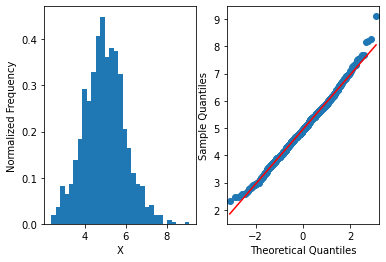

In [2]:
%matplotlib inline

np.random.seed(2)

X = np.random.normal(loc=5, scale=1, size=1000)

fig, axs = plt.subplots(1, 2)

_ = axs[0].hist(X, bins=int(np.sqrt(1000)), density=True)
_ = axs[0].set_xlabel('X')
_ = axs[0].set_ylabel('Normalized Frequency')

_ = qqplot(X, line='s', ax=axs[1])

On the histogram and the QQ plot, this data looks normal.

In [3]:
CDF = partial(norm.cdf, loc=5, scale=1)

stat, p = kstest(X, CDF)

print(stat, p)

0.03702525828771641 0.12571271940759232


This is not statistically significant.

The values 0.03670186250394453 and 0.03702525828771641 are "equal"?: True


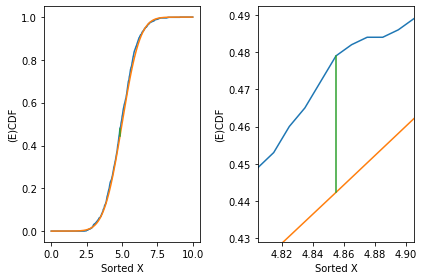

In [4]:
e = ECDF(X)

test_pts = np.linspace(0, 10, 1000)

D = np.max(np.abs(e(test_pts) - CDF(test_pts)))
ihat = np.argmax(np.abs(e(test_pts) - CDF(test_pts)))

xhat = test_pts[ihat]

fig, axs = plt.subplots(1, 2)

for a in axs:
    a.plot(test_pts, e(test_pts))
    a.plot(test_pts, CDF(test_pts))
    a.plot([xhat, xhat], [e(xhat), CDF(xhat)])
    a.set_xlabel('Sorted X')
    a.set_ylabel('(E)CDF')
    
axs[1].set_xlim(xhat - .05, xhat + .05)
axs[1].set_ylim(e(xhat) - .05, CDF(xhat) + .05)
print(f'The values {D} and {stat} are "equal"?: {np.allclose([D], [stat], atol=1e-3)}')

plt.tight_layout()

In [5]:
for size in range(1, 10):
    Y = []
    for i in range(1000):
        Y.append(np.mean(np.random.poisson(lam=5.0, size=5 * size)))
    
    out = kstest(Y, partial(norm.cdf, loc=np.mean(Y), scale=np.std(Y)))
    
    if out[1] > 0.05:
        print(f"An average of size {5 * size} approximates the normal distribution with p = {out[1]:.02f}")
        break

An average of size 10 approximates the normal distribution with p = 0.08


## Problem 2 - Linear Analysis
Often when comparing two measurements of a single quantity, we're interested in the linear relationship between these measurements, the degree of correlation, and any bias observed between the two measurements. We'll introduce some tools to quantify linear relationships between two measurements. For this problem, we'll use the dataset `myocardial_mass.csv` that contains measurements of myocardial mass in grams by cardiac MRI from two observers O1 and O2.

### Part 2A - Linear Regression
What is the slope of best fit? Intercept of best fit? Overplot the data and line of best fit on the same axes. 

### Part 2B - Pearson $r$ Correlation
Pearson $r$ ($\in [-1, 1]$) denotes the degree of positive or negative linear correlation between two measurements. If $r > 0$, there is positive correlation. If $r < 0$, there is negative correlation. 0 denotes no correlation, and $\pm$1 denotes maximal linear correlation. What is the Pearson $r$ correlation between O1 and O2? Is this significant at the level $\alpha = 0.05$?

### Part 2C - Bland-Altman Analysis
Bland-Altman plots are useful for characterizing bias between two measurements at multiple value scales. Make a Bland-Altman plot for O1 and O2 using the following steps.

* Compute A = (O1 + O2)/2
* Compute B = O2 - O1
* Compute the mean $\mu$ and standard deviation $\sigma$ of B
* Plot A on the x axis and B on the y axis
* Plot horizontal lines at y=0 and y=$\mu$. If the data has minimal mean bias, $\mu$ should be close to 0.
* Plot horizontal lines at y=$\mu \pm 1.96\sigma$. These are the limits of agreement and determine the variability between O1 and O2. 

What is the mean bias and the limits of agreement? What can you interpret from the plot?

Slope = 0.09, Intercept=75.65


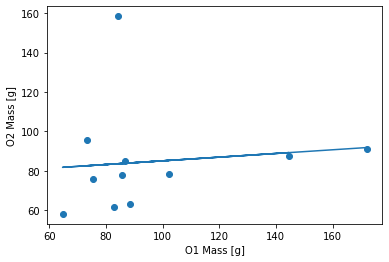

In [6]:
mass = pd.read_csv('myocardial_mass.csv')

def line(x, m, b):
    return m * x + b

O1 = mass["O1"].values.reshape(-1, 1)
O2 = mass["O2"].values.reshape(-1, 1)

lr = LinearRegression()
lr.fit(O1, O2)

m = lr.coef_[0][0]
b = lr.intercept_[0]

plt.scatter(O1, O2)
plt.plot(O1, line(O1, m, b))
plt.xlabel('O1 Mass [g]')
plt.ylabel('O2 Mass [g]')

print(f"Slope = {m:.02f}, Intercept={b:.02f}")

In [7]:
r, p = pearsonr(O1.flatten(), O2.flatten())
print(f"Statistic = {r}, p = {p}")
print(f"This is not statistically significant.")

Statistic = 0.11179105391076913, p = 0.7434864111635732
This is not statistically significant.


Mean Difference=-11.74
Limits=-86.85,63.36


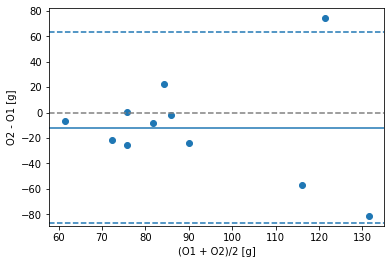

In [8]:
def bland_altman(a, b, ax, verbose=False):
    out= ax.scatter((a + b)/2., b - a)
    line = ax.axhline(np.mean(b - a))
    ax.axhline(np.mean(b - a) + 1.96 * np.std(b - a), ls='--')
    ax.axhline(np.mean(b - a) - 1.96 * np.std(b - a), ls='--')
    ax.axhline(0, ls='--', color='gray')
    if verbose:
        print(f"Mean Difference={np.mean(b - a):.02f}")
        print(f"Limits={np.mean(b - a) - 1.96 * np.std(b - a):.02f},{np.mean(b - a) + 1.96 * np.std(b - a):.02f}")
    return out, line

ax = plt.gca()
plt.xlabel('(O1 + O2)/2 [g]')
plt.ylabel('O2 - O1 [g]')
bland_altman(O1, O2, ax, verbose=True)
plt.show()

There is little bias at lower measurement values for the mass, and high bias in both directions at higher measurement values for the mass.

## Problem 3 - Basic Statistical Tests
Here, we introduce some basic statistical tests to determine if two distributions are statistically significant from each other. For this problem, we'll be looking at differences in effective temperature (measured in Kelvin) of two types of stars: Type 1 stars host planets, and Type 2 stars are the control population. 

### Part 3A - Z Score
Compute the Z score for each of the stars. What is the average Z score? Plot a histogram of the data and the z scores. 

### Part 3B- $t$ Test

Using a student's $t$-test (`ttest_ind`), determine if there is statistical significance between Type 1 stars and Type 2 stars at the level $\alpha=0.05$. Do the assumptions of the $t$-test hold for these distributions?


### Part 3C - One-tailed vs Two-tailed Tests
In the `ttest_ind` function, try passing in different values ('less', 'greater', 'two-sided') for the `alternative` flag. Which of these flags make the most sense?

In [9]:
data = np.genfromtxt('censor.dat', skip_header=1)

df = pd.DataFrame()
df["StarType"] = data[:, 1]
df["EffTemp"] = data[:, 2]

type_1 = df.loc[df["StarType"] == 1.]["EffTemp"]
type_2 = df.loc[df["StarType"] == 2.]["EffTemp"]

Average Z score is 2.873518416676876e-16


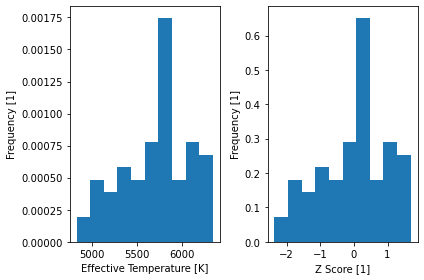

In [10]:
zsc = zscore(df["EffTemp"])
print(f'Average Z score is {np.mean(zsc)}')

fig, axs = plt.subplots(1, 2)
axs[0].hist(df["EffTemp"], density=True)
axs[0].set_xlabel('Effective Temperature [K]')
axs[0].set_ylabel('Frequency [1]')

axs[1].hist(zsc, density=True)
axs[1].set_xlabel('Z Score [1]')
axs[1].set_ylabel('Frequency [1]')
plt.tight_layout()
plt.show()

In [11]:
type1_CDF = partial(norm.cdf, loc=np.mean(type_1), scale=np.std(type_1))
type1_ks = kstest(type_1, type1_CDF)

type2_CDF = partial(norm.cdf, loc=np.mean(type_2), scale=np.std(type_2))
type2_ks = kstest(type_2, type2_CDF)

print(type1_ks, type2_ks)

KstestResult(statistic=0.10184681765828074, pvalue=0.775702285038655) KstestResult(statistic=0.1338421203042085, pvalue=0.6284602582174117)


These are not statistically distinct from the normal distribution, so the assumptions of the t test are valid.

In [12]:
tt, p = ttest_ind(type_1, type_2)
print(tt, p)

2.1309754806685874 0.036820568555484115


These are statistically significant at the level $\alpha=0.05$.

In [13]:
print(np.mean(type_1), np.mean(type_2))

5789.74358974359 5598.3448275862065


These mean values are close to each other, so a 2-tailed t test is valid. We can also try a 1-tailed t test with the 'greater' flag, since the mean of sample 1 is greater than the mean of sample 2.

In [14]:
tt, p = ttest_ind(type_1, type_2, alternative='greater')
print(tt, p)

2.1309754806685874 0.018410284277742058


This is also statistically significant at the level $\alpha=0.05$.